In [30]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from utils.finance_utils import get_financial_data

# Load financial data

In [31]:
df = get_financial_data(start_date="2020-01-01")
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Daily Return,Lagged Return,Log Return,SMA 14,ATR 14
Date,,,,,,,,,,
2020-01-02,72.620834,72.681281,71.373211,71.627084,135480400,0.013874,0.007307,0.022560,68.729436,1.109459
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800,0.000942,0.022816,-0.009770,69.177951,1.089426
2020-01-06,72.487862,72.526549,70.783263,71.034724,118387200,0.020457,-0.009722,0.007937,69.603670,1.138474
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000,-0.004836,0.007968,-0.004714,69.923694,1.100133
2020-01-08,73.307495,73.609729,71.849518,71.849518,132079200,0.020292,-0.004703,0.015958,70.317116,1.174569


# Converting Pandas DataFrame to NumPy ndarray

In [32]:
X = df.to_numpy()
X.shape

(1393, 10)

# Split and scale

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}')

Train: (1114, 10), Test: (279, 10)


# Create sequences

In [34]:
from utils.torch_utils import create_sequence

X_train_seq, y_train_seq = create_sequence(X_train_scaled, input_seq_len=10)
X_test_seq, y_test_seq = create_sequence(X_test_scaled, input_seq_len=7)

print(f'X_train, y_train: {X_train_seq.shape} {y_train_seq.shape}')
print(f'X_test, y_test: {X_test_seq.shape} {y_test_seq.shape}')

X_train, y_train: (1103, 10, 10) (1103, 10)
X_test, y_test: (271, 7, 10) (271, 10)


# Data preparation

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Convert ndarray to torch Tensor
X_train_seq, X_test_seq, y_train_seq, y_test_seq = torch.Tensor(X_train_seq), torch.Tensor(X_test_seq), torch.Tensor(y_train_seq), torch.Tensor(y_test_seq)
# Put tensors to available device
X_train_seq, X_test_seq, y_train_seq, y_test_seq = X_train_seq.to(device), X_test_seq.to(device), y_train_seq.to(device), y_test_seq.to(device)

# Add sequence dimension (Transformer needs both input and output to be sequences) [(batch_size, n_features) -> (batch_size, 1, n_features)]
y_train_seq, y_test_seq = y_train_seq.unsqueeze(1), y_test_seq.unsqueeze(1)

cuda


In [36]:
from utils.torch_utils import StockDataset

batch_size = 128

dataset_train = StockDataset(X_train_seq, y_train_seq)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test_seq, y_test_seq)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Model definition

In [37]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, num_layers=6, dim_ff=2048, dropout=0.1, max_len=5000):
        super(TransformerModel, self).__init__()
        
        self.pos_encoder = PositionalEncoding(input_dim, max_len=max_len)
        self.pos_decoder = PositionalEncoding(input_dim, max_len=max_len)
        
        self.transformer = nn.Transformer(
            d_model=input_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_ff, 
            dropout=dropout,
            batch_first=True
        )
        
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, src, tgt, tgt_mask=None):
        # Add positional encoding
        src = self.pos_encoder(src)
        tgt = self.pos_decoder(tgt)
        
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        output = self.fc_out(output)
        return output
    
    def generate_autoregressive(self, src, target_len=None):

        self.eval()
        with torch.no_grad():

            batch_size = src.size(0)
            tgt_len = target_len if target_len is not None else src.size(1)
            num_features = src.size(2)

            # Autoregressive prediction
            decoder_input = torch.zeros((batch_size, 1, num_features), device=device)
            predictions = []

            for t in range(tgt_len):
                tgt_mask = nn.Transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(device)
                output = self.forward(X, decoder_input, tgt_mask=tgt_mask)
                next_step = output[:, -1:, :]
                predictions.append(next_step)
                decoder_input = torch.cat([decoder_input, next_step], dim=1)

            preds = torch.cat(predictions, dim=1)  # (B, tgt_len, num_features)
            return preds

In [38]:
n_features = 10
num_layers = 3
num_heads = 5
dropout = 0.1

model = TransformerModel(input_dim=n_features, output_dim=n_features, num_heads=num_heads, dropout=dropout, num_layers=num_layers)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/grozd/Programi/Python_venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


# Model training

In [39]:
from datetime import datetime

epochs = 500
train_per_epoch = int(len(dataset_train) / batch_size)

model.train()

for epoch in range(epochs+1):

    epoch_loss = 0

    for (data, target) in dataloader_train:

        # Decoder input: zeros as start token (shape same as tgt_true)
        tgt_input = torch.zeros_like(target).to(device)

        # Causal mask for tgt_len=1 (no future tokens, mask will be zero)
        tgt_len = tgt_input.size(1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(device)

        output = model(data, tgt_input, tgt_mask=tgt_mask)  # output: (B, 1, 10)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch) % 10 == 0:
        print(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")

timestamp = datetime.now().strftime("%d-%m-%Y")
torch.save(model.state_dict(), f"models/transformer_m2o_{timestamp}.pth")

Epoch 0/500 Avg Loss: 1.2470
Epoch 10/500 Avg Loss: 0.6497
Epoch 20/500 Avg Loss: 0.5344
Epoch 30/500 Avg Loss: 0.4966
Epoch 40/500 Avg Loss: 0.4847
Epoch 50/500 Avg Loss: 0.4213
Epoch 60/500 Avg Loss: 0.4211
Epoch 70/500 Avg Loss: 0.4356
Epoch 80/500 Avg Loss: 0.3991
Epoch 90/500 Avg Loss: 0.4026
Epoch 100/500 Avg Loss: 0.3984
Epoch 110/500 Avg Loss: 0.3745
Epoch 120/500 Avg Loss: 0.4036
Epoch 130/500 Avg Loss: 0.3758
Epoch 140/500 Avg Loss: 0.3755
Epoch 150/500 Avg Loss: 0.3619
Epoch 160/500 Avg Loss: 0.4117
Epoch 170/500 Avg Loss: 0.3672
Epoch 180/500 Avg Loss: 0.3630
Epoch 190/500 Avg Loss: 0.3636
Epoch 200/500 Avg Loss: 0.3810
Epoch 210/500 Avg Loss: 0.3539
Epoch 220/500 Avg Loss: 0.3538
Epoch 230/500 Avg Loss: 0.4082
Epoch 240/500 Avg Loss: 0.3568
Epoch 250/500 Avg Loss: 0.3504
Epoch 260/500 Avg Loss: 0.3702
Epoch 270/500 Avg Loss: 0.3588
Epoch 280/500 Avg Loss: 0.3554
Epoch 290/500 Avg Loss: 0.3333
Epoch 300/500 Avg Loss: 0.3341
Epoch 310/500 Avg Loss: 0.3301
Epoch 320/500 Avg L

# Model evaluation

In [40]:
model.eval()

with torch.no_grad():

    tgt_input = torch.zeros(X_test_seq.size(0), 1, X_test_seq.size(2)).to(device)
    preds = model(X_test_seq.to(device), tgt_input)

    val_loss = criterion(preds, y_test_seq)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 1.407578468322754


# Plot train results

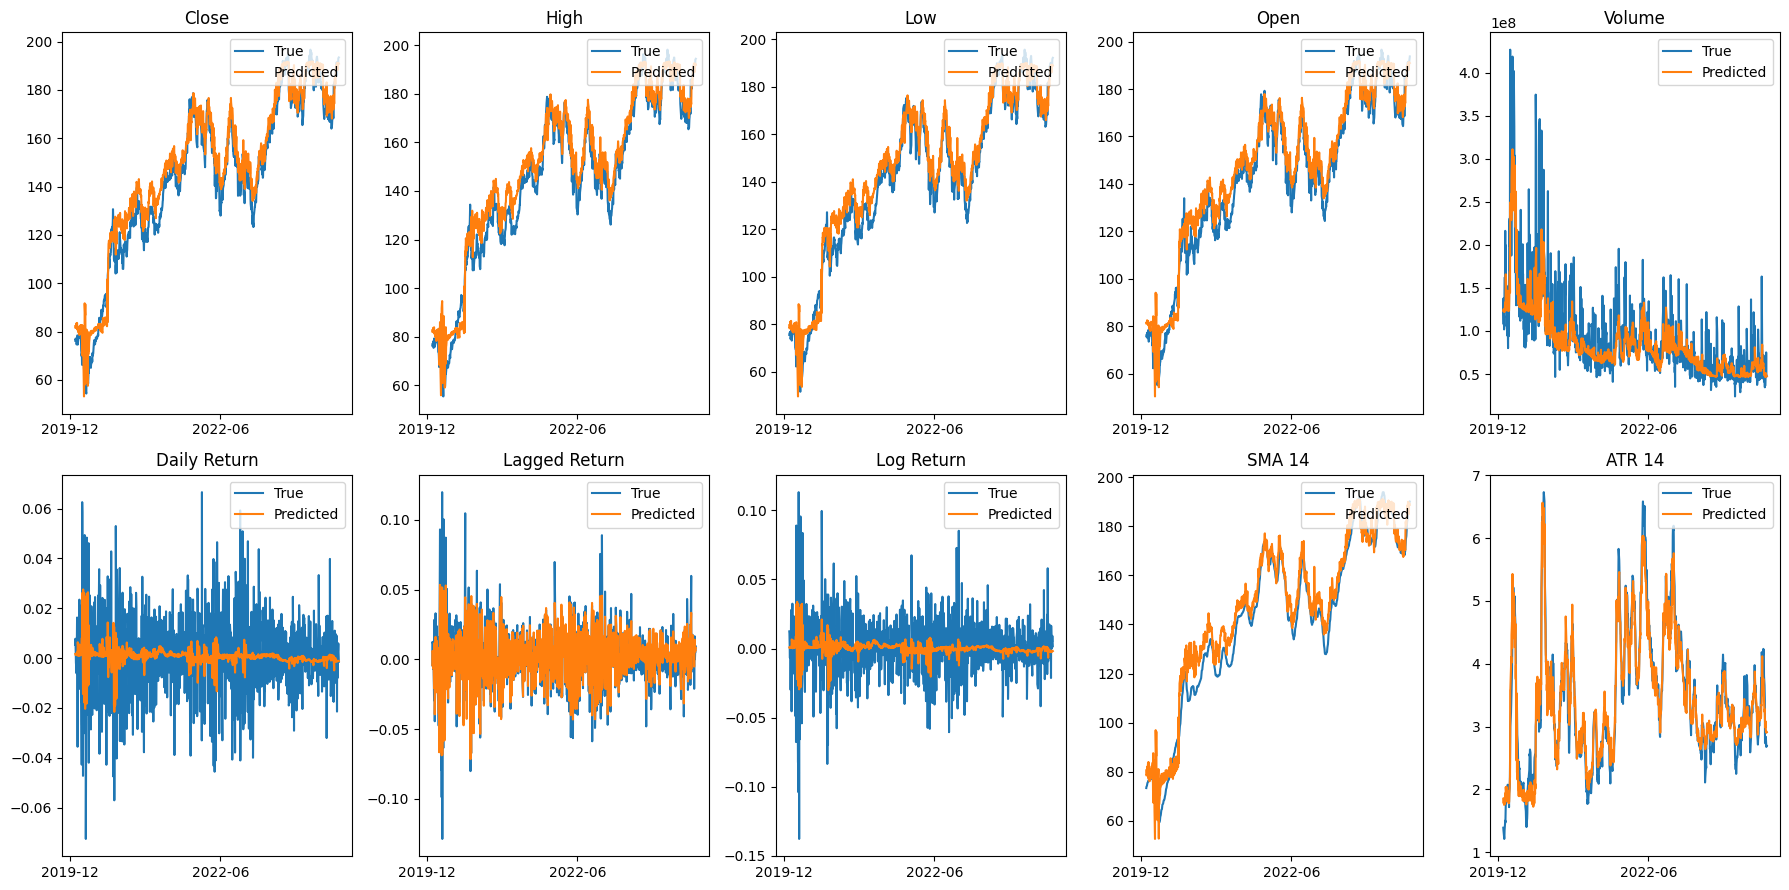

In [41]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

tgt_input = torch.zeros(X_train_seq.size(0), 1, X_train_seq.size(2)).to(device)

y_true = scaler.inverse_transform(y_train_seq.squeeze(1).cpu().detach().numpy())
y_pred = model(X_train_seq, tgt_input).squeeze(1).cpu().detach().numpy()
y_pred = scaler.inverse_transform(y_pred)

train_dates = df.index[:len(X_train_seq)]

for idx, c in enumerate(df.columns):
    axes[idx].plot(train_dates, y_true[:, idx], color='#1f77b4', label='True')
    axes[idx].plot(train_dates, y_pred[:, idx], color='#ff7f0e', label='Predicted')
    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=30))

plt.tight_layout()
plt.show()

# Plotting test results

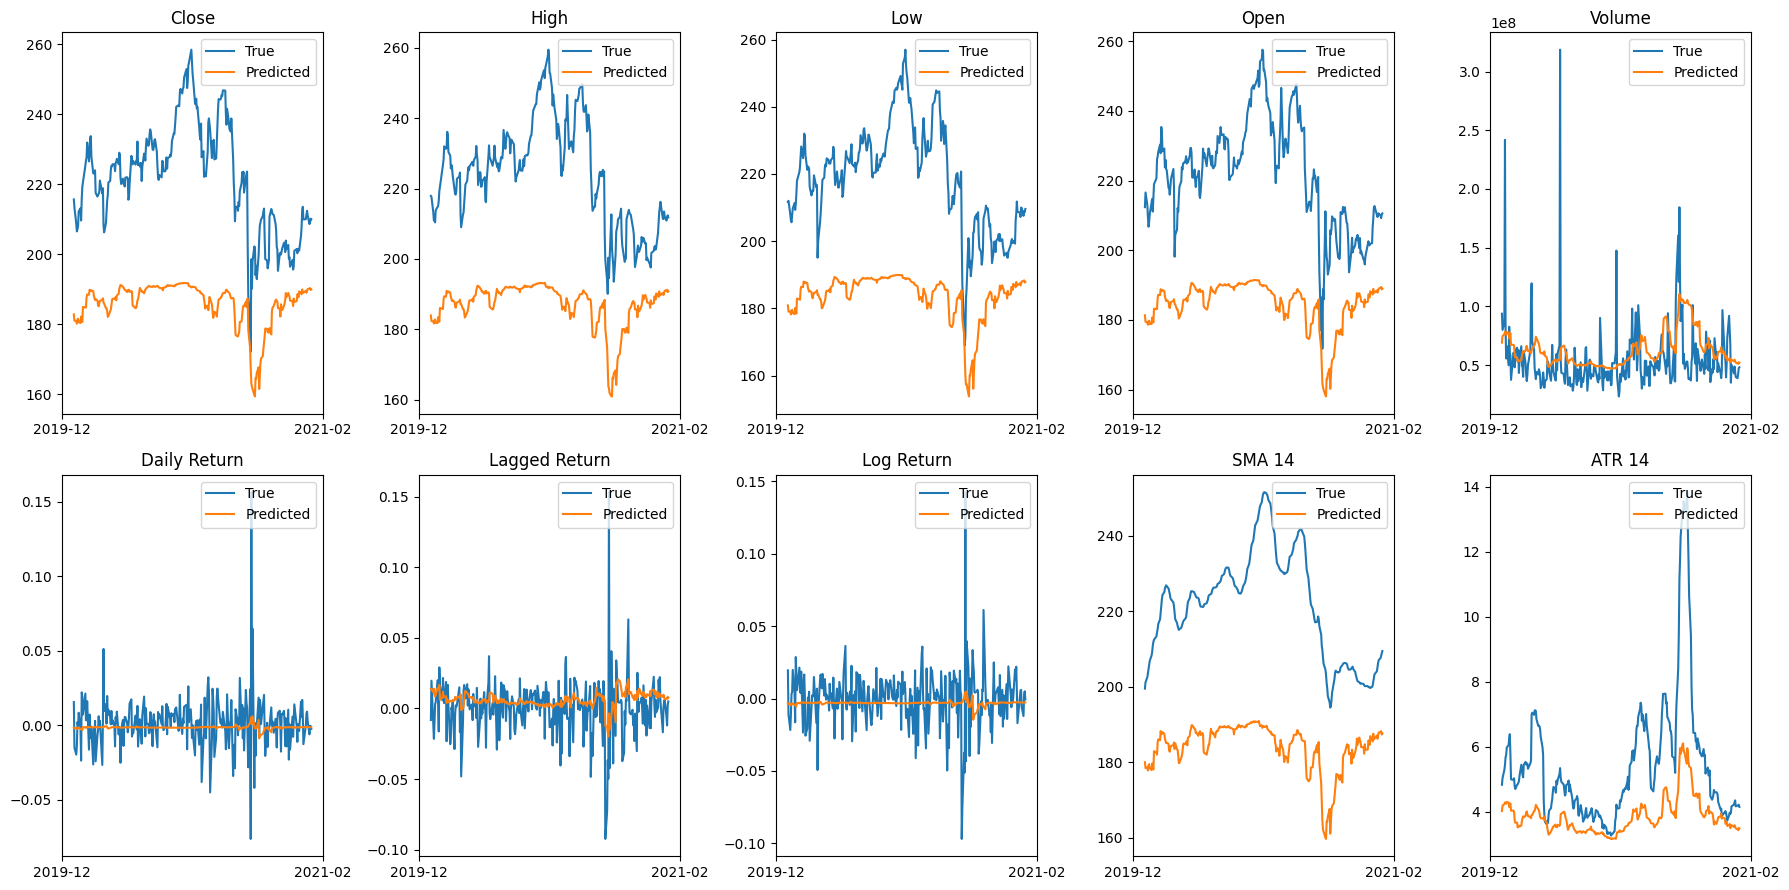

In [42]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

tgt_input = torch.zeros(X_test_seq.size(0), 1, X_test_seq.size(2)).to(device)

y_true = scaler.inverse_transform(y_test_seq.squeeze(1).cpu().detach().numpy())
y_pred = model(X_test_seq, tgt_input).squeeze(1).cpu().detach().numpy()
y_pred = scaler.inverse_transform(y_pred)

test_dates = df.index[:len(X_test_seq)]

for idx, c in enumerate(df.columns):
    axes[idx].plot(test_dates, y_true[:, idx], color='#1f77b4', label='True')
    axes[idx].plot(test_dates, y_pred[:, idx], color='#ff7f0e', label='Predicted')
    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=30))

plt.tight_layout()
plt.show()

# Create sequences

- many-to-many

In [43]:
X_train_seq, y_train_seq = create_sequence(X_train_scaled, input_seq_len=10, target_seq_len=10)
X_test_seq, y_test_seq = create_sequence(X_test_scaled, input_seq_len=7, target_seq_len=7)

print(f'X_train, y_train: {X_train_seq.shape} {y_train_seq.shape}')
print(f'X_test, y_test: {X_test_seq.shape} {y_test_seq.shape}')

X_train, y_train: (1094, 10, 10) (1094, 10, 10)
X_test, y_test: (265, 7, 10) (265, 7, 10)


In [44]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = torch.Tensor(X_train_seq), torch.Tensor(X_test_seq), torch.Tensor(y_train_seq), torch.Tensor(y_test_seq)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = X_train_seq.to(device), X_test_seq.to(device), y_train_seq.to(device), y_test_seq.to(device)

In [45]:
batch_size = 128

dataset_train = StockDataset(X_train_seq, y_train_seq)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test_seq, y_test_seq)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [46]:
n_features = 10
num_layers = 3
num_heads = 5
dropout = 0.3

model = TransformerModel(input_dim=n_features, output_dim=n_features, num_heads=num_heads, dropout=dropout, num_layers=num_layers)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/grozd/Programi/Python_venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [47]:
epochs = 500
train_per_epoch = int(len(dataset_train) / batch_size)

model.train()

for epoch in range(epochs+1):

    epoch_loss = 0

    for (data, target) in dataloader_train:

        tgt_input = torch.zeros_like(target)
        tgt_input[:, 1:, :] = target[:, :-1, :]  # shift right

        tgt_len = tgt_input.size(1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(device)

        output = model(data, tgt_input, tgt_mask=tgt_mask)  # shape: (B, 10, 10)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch) % 10 == 0:
        print(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")

timestamp = datetime.now().strftime("%d-%m-%Y")
torch.save(model.state_dict(), f"models/transformer_m2m_{timestamp}.pth")

Epoch 0/500 Avg Loss: 1.4146
Epoch 10/500 Avg Loss: 0.6694
Epoch 20/500 Avg Loss: 0.5797
Epoch 30/500 Avg Loss: 0.5189
Epoch 40/500 Avg Loss: 0.4465
Epoch 50/500 Avg Loss: 0.4161
Epoch 60/500 Avg Loss: 0.4036
Epoch 70/500 Avg Loss: 0.3931
Epoch 80/500 Avg Loss: 0.3886
Epoch 90/500 Avg Loss: 0.3521
Epoch 100/500 Avg Loss: 0.3591
Epoch 110/500 Avg Loss: 0.3521
Epoch 120/500 Avg Loss: 0.3356
Epoch 130/500 Avg Loss: 0.3518
Epoch 140/500 Avg Loss: 0.3441
Epoch 150/500 Avg Loss: 0.3297
Epoch 160/500 Avg Loss: 0.3228
Epoch 170/500 Avg Loss: 0.3128
Epoch 180/500 Avg Loss: 0.3166
Epoch 190/500 Avg Loss: 0.3170
Epoch 200/500 Avg Loss: 0.3097
Epoch 210/500 Avg Loss: 0.3282
Epoch 220/500 Avg Loss: 0.3021
Epoch 230/500 Avg Loss: 0.3059
Epoch 240/500 Avg Loss: 0.2921
Epoch 250/500 Avg Loss: 0.2934
Epoch 260/500 Avg Loss: 0.2949
Epoch 270/500 Avg Loss: 0.2889
Epoch 280/500 Avg Loss: 0.2870
Epoch 290/500 Avg Loss: 0.2858
Epoch 300/500 Avg Loss: 0.2793
Epoch 310/500 Avg Loss: 0.2831
Epoch 320/500 Avg L

In [53]:
model.eval()

with torch.no_grad():

    tgt_input = torch.zeros_like(X_test_seq).to(device)
    preds = model(X_test_seq.to(device), tgt_input)

    val_loss = criterion(preds, y_test_seq)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 2.0115840435028076


In [54]:
model.eval()
with torch.no_grad():

    batch_size = X_test_seq.size(0)
    tgt_len = y_test_seq.size(1)
    num_features = y_test_seq.size(2)

    # Autoregressive prediction
    decoder_input = torch.zeros((batch_size, 1, num_features), device=device)
    predictions = []

    for t in range(tgt_len):
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(device)
        output = model(X_test_seq, decoder_input, tgt_mask=tgt_mask)
        next_step = output[:, -1:, :]
        predictions.append(next_step)
        decoder_input = torch.cat([decoder_input, next_step], dim=1)

    preds = torch.cat(predictions, dim=1)  # (B, tgt_len, num_features)
    loss = criterion(preds, y_test_seq)

    print(f"Validation Loss: {loss.item()}")

Validation Loss: 1.6015338897705078


In [55]:
def predict_autoregressive(model, X, y):
    model.eval()
    with torch.no_grad():

        batch_size = X.size(0)
        tgt_len = y.size(1)
        num_features = y.size(2)

        # Autoregressive prediction
        decoder_input = torch.zeros((batch_size, 1, num_features), device=device)
        predictions = []

        for t in range(tgt_len):
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(device)
            output = model(X, decoder_input, tgt_mask=tgt_mask)
            next_step = output[:, -1:, :]
            predictions.append(next_step)
            decoder_input = torch.cat([decoder_input, next_step], dim=1)

        preds = torch.cat(predictions, dim=1)  # (B, tgt_len, num_features)
        return preds

# Plot train results (one random sequence)

(10, 10)


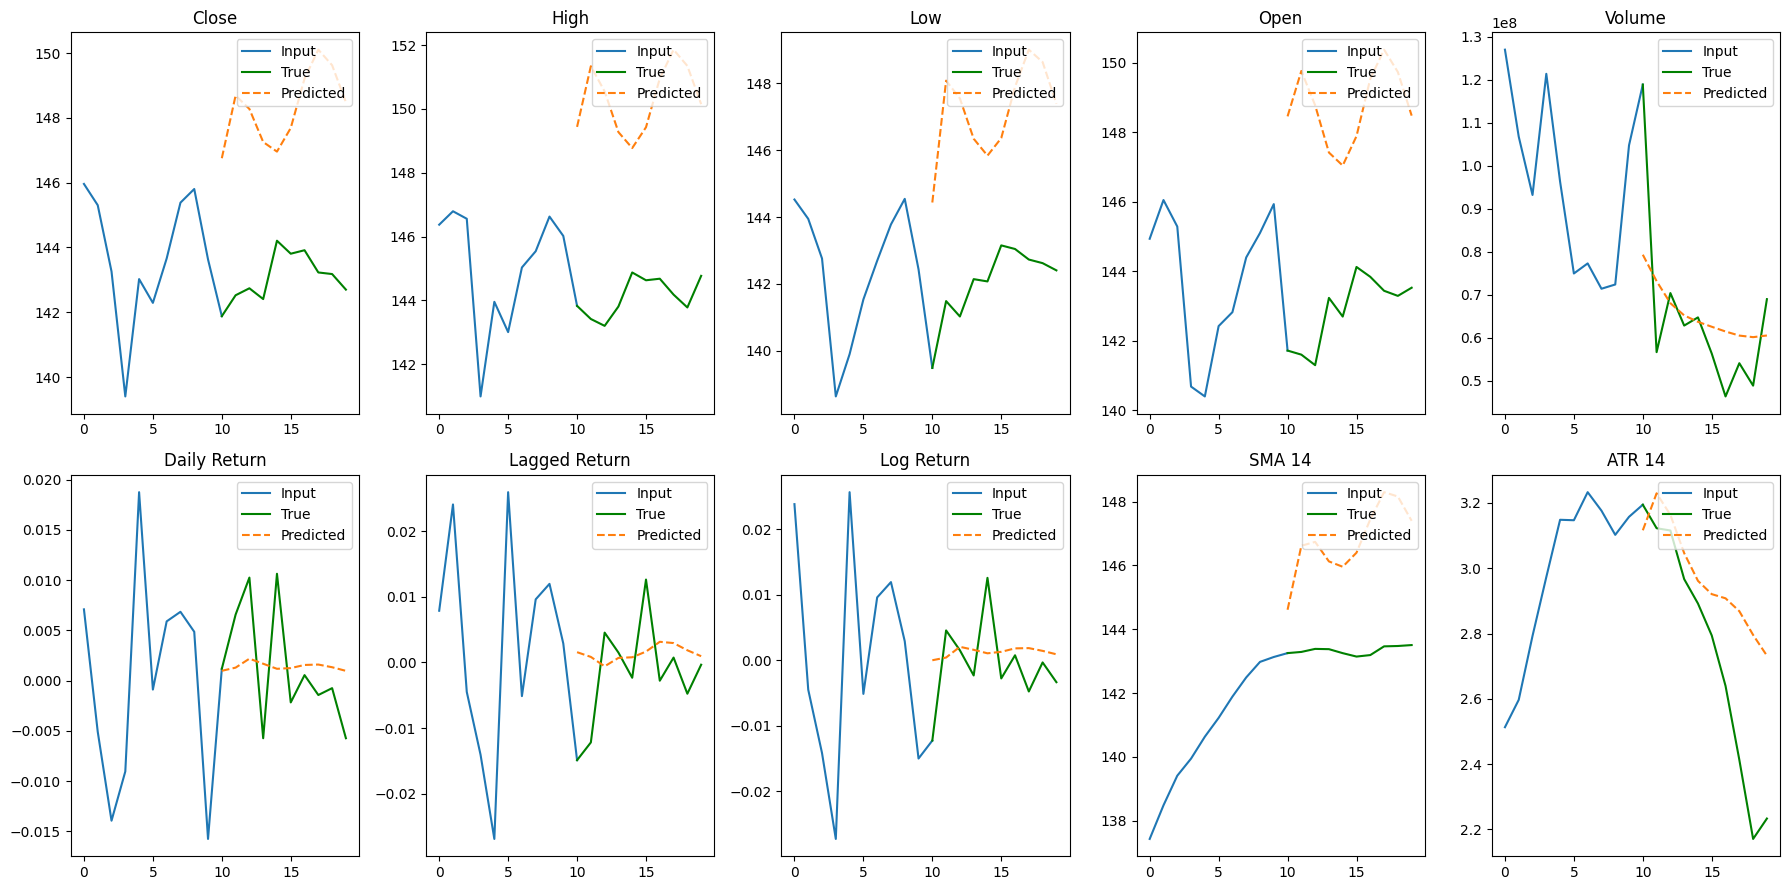

In [56]:
rand_idx = np.random.randint(0, len(X_train_seq))

x = X_train_seq[rand_idx].cpu().detach().numpy()

y_true = y_train_seq[rand_idx].cpu().detach().numpy()
y_pred = predict_autoregressive(model, X_train_seq, y_train_seq)[rand_idx].cpu().detach().numpy()

print(f'{y_pred.shape}')

x = scaler.inverse_transform(x)
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

for idx, c in enumerate(df.columns):

    input_seq = x[:, idx]
    true_seq = y_true[:, idx]
    pred_seq = y_pred[:, idx]

    axes[idx].plot(range(len(input_seq)+1), np.hstack((input_seq, true_seq[0])), label='Input', color='#1f77b4')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(true_seq)), true_seq, label='True', color='green')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='Predicted', color='#ff7f0e', linestyle='dashed')

    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Plot test results (one random sequence)

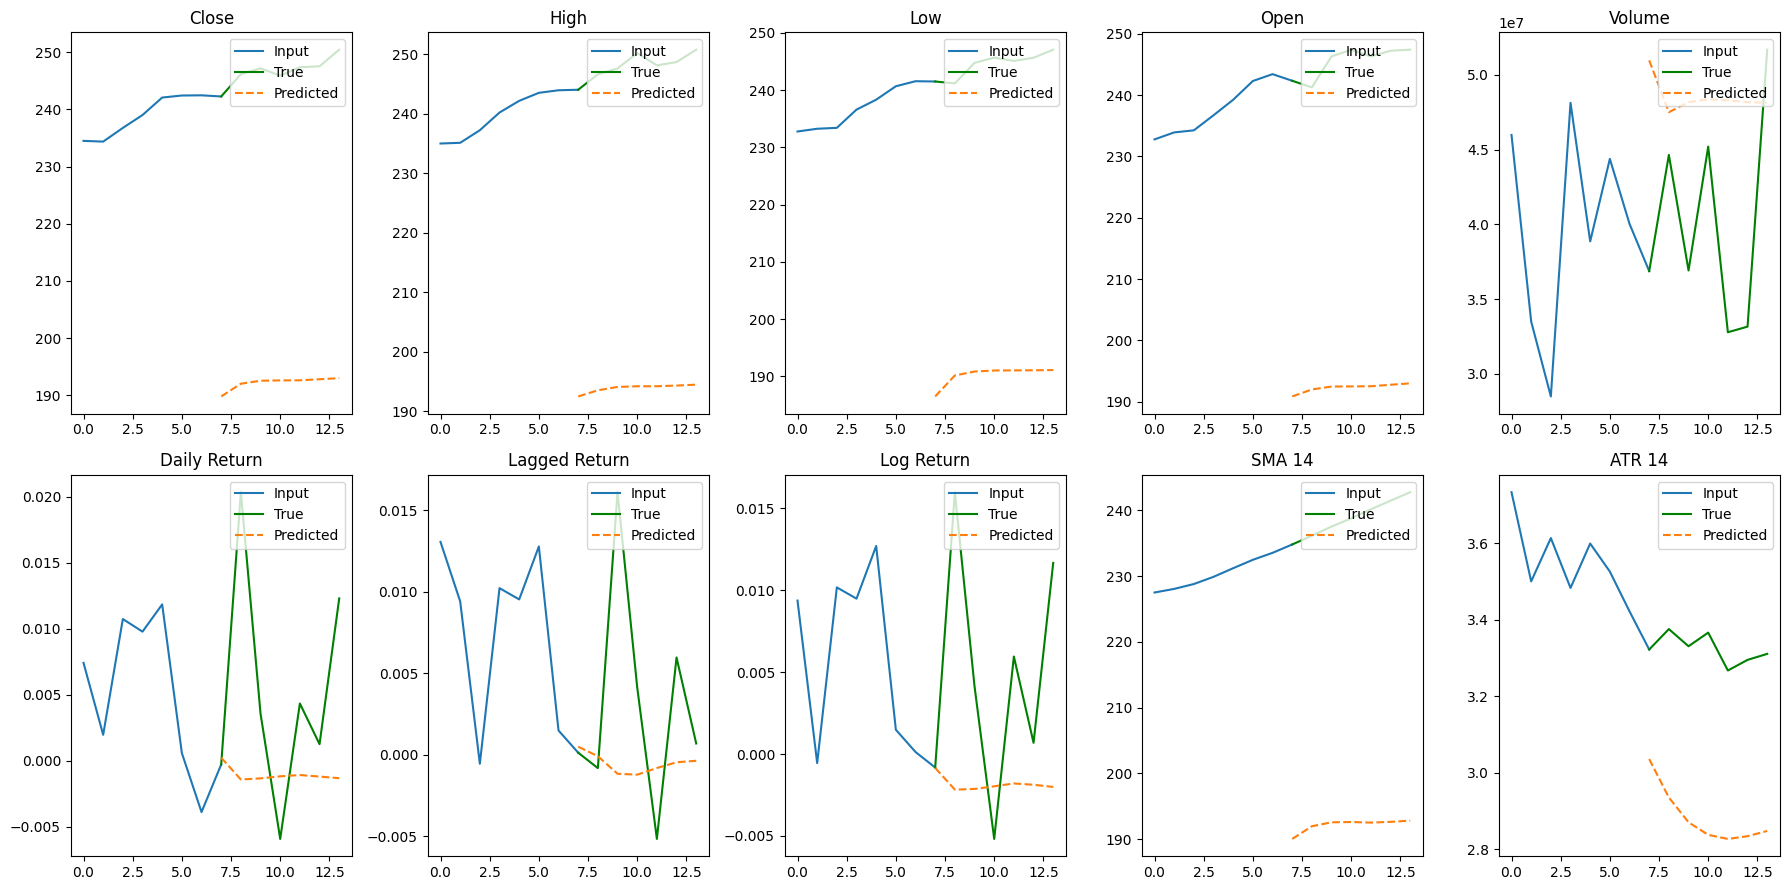

In [57]:
rand_idx = np.random.randint(0, len(X_test_seq))

x = X_test_seq[rand_idx].cpu().detach().numpy()
y_true = y_test_seq[rand_idx].cpu().detach().numpy()
y_pred = predict_autoregressive(model, X_test_seq, y_test_seq)[rand_idx].cpu().detach().numpy()

x = scaler.inverse_transform(x)
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

for idx, c in enumerate(df.columns):

    input_seq = x[:, idx]
    true_seq = y_true[:, idx]
    pred_seq = y_pred[:, idx]

    axes[idx].plot(range(len(input_seq)+1), np.hstack((input_seq, true_seq[0])), label='Input', color='#1f77b4')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(true_seq)), true_seq, label='True', color='green')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='Predicted', color='#ff7f0e', linestyle='dashed')

    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()